# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


## Model Definition

### Setup response model

In [4]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)


smooth = tb.ps("area", k=20)

loc += smooth
loc += tb.rs(x=smooth, cluster="district")

loc += tb.ri("district", factor_scale=True)

Warning message:
In smooth.construct.ps.smooth.spec(object, dk$data, dk$knots) :
  there is *no* information about some basis coefficients
Warning message:
In smooth.construct.ps.smooth.spec(object, dk$data, dk$knots) :
  there is *no* information about some basis coefficients


### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


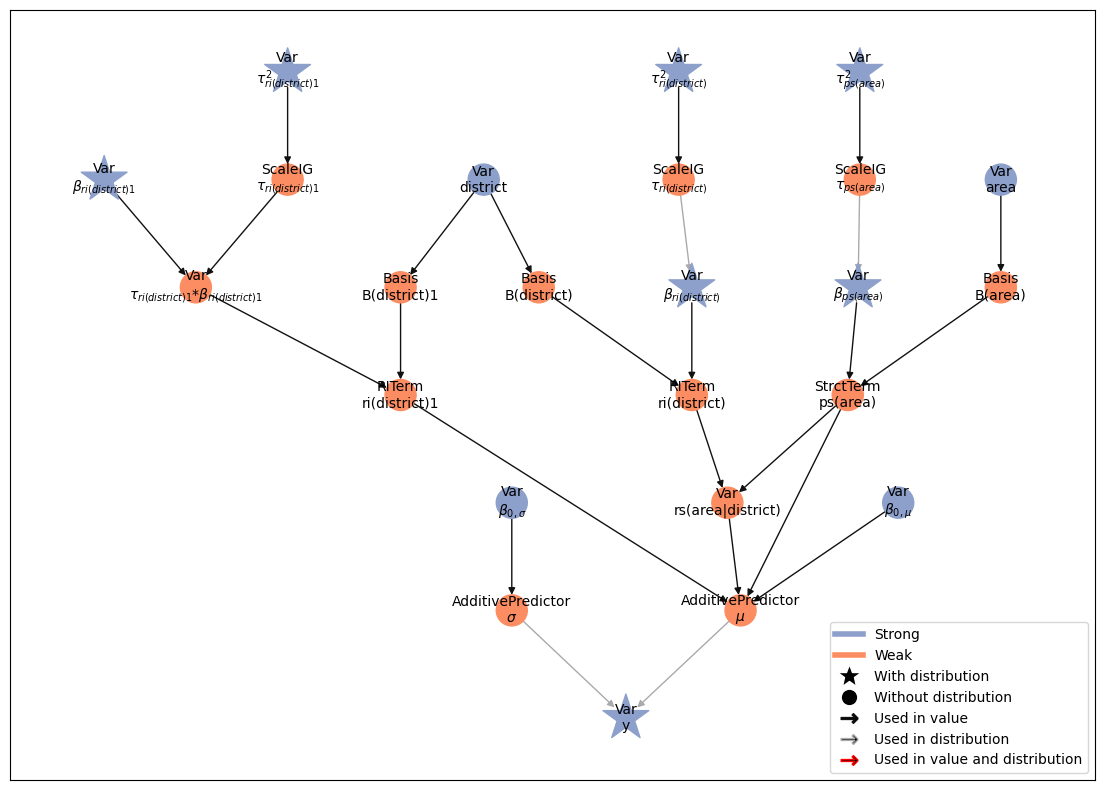

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ri(district)1}$', '$\\tau_{ri(district)1}^2$', '$\\beta_{ri(district)}$', '$\\tau_{ri(district)}^2$', '$\\beta_{ps(area)}$', '$\\tau_{ps(area)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.92chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [7]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel        mean         sd     q_0.05  \
parameter                index                                                
$\beta_{0,\mu}$          ()     kernel_01   34.560280   1.562532  32.490276   
$\beta_{0,\sigma}$       ()     kernel_00   -2.314584   5.060426 -10.453270   
$\beta_{ps(area)}$       (0,)   kernel_06   -0.034334   0.436838  -0.602005   
                         (1,)   kernel_06    0.055793   0.478513  -0.589033   
                         (2,)   kernel_06   -0.099708   0.400067  -0.622008   
...                                   ...         ...        ...        ...   
$\beta_{ri(district)}$   (47,)  kernel_04   -0.065835   0.111461  -0.212778   
                         (48,)  kernel_04    0.039685   0.176952  -0.132460   
$\tau_{ps(area)}^2$      ()     kernel_07    0.198391   0.231142   0.009850   
$\tau_{ri(district)1}^2$ ()     kernel_03  106.969002  94.016472   0.002374   
$\tau_{ri(district)}^2$  ()     kernel_05    0.018785   0.025597   0.002189   

                                     q_0.5      q_0.95  sample_size  \
parameter                index                                        
$\beta_{0,\mu}$          ()      34.752068   37.517949         4000   
$\beta_{0,\sigma}$       ()      -0.725150    2.772572         4000   
$\beta_{ps(area)}$       (0,)    -0.059070    0.686317         4000   
                         (1,)    -0.034411    0.955265         4000   
                         (2,)    -0.091584    0.558553         4000   
...                                    ...         ...          ...   
$\beta_{ri(district)}$   (47,)   -0.086043    0.111801         4000   
                         (48,)    0.000329    0.360946         4000   
$\tau_{ps(area)}^2$      ()       0.148903    0.524625         4000   
$\tau_{ri(district)1}^2$ ()     144.080162  236.058330         4000   
$\tau_{ri(district)}^2$  ()       0.008328    0.053526         4000   

                                 ess_bulk    ess_tail      rhat  
parameter                index                                   
$\beta_{0,\mu}$          ()     18.735609  134.285662  1.467820  
$\beta_{0,\sigma}$       ()      5.444350   12.086463  1.986426  
$\beta_{ps(area)}$       (0,)   17.202776  336.204159  1.155748  
                         (1,)   20.653830  102.445664  1.144747  
                         (2,)   24.052051  821.728335  1.115812  
...                                   ...         ...       ...  
$\beta_{ri(district)}$   (47,)  14.770707  105.533097  1.603224  
                         (48,)   7.448330   16.829189  1.493100  
$\tau_{ps(area)}^2$      ()     23.183294  175.114580  1.126574  
$\tau_{ri(district)1}^2$ ()      7.647214   76.696954  1.479171  
$\tau_{ri(district)}^2$  ()     16.129285   87.178800  1.317112  

[122 rows x 10 columns]

## Plots

In [8]:
samples = results.get_posterior_samples()

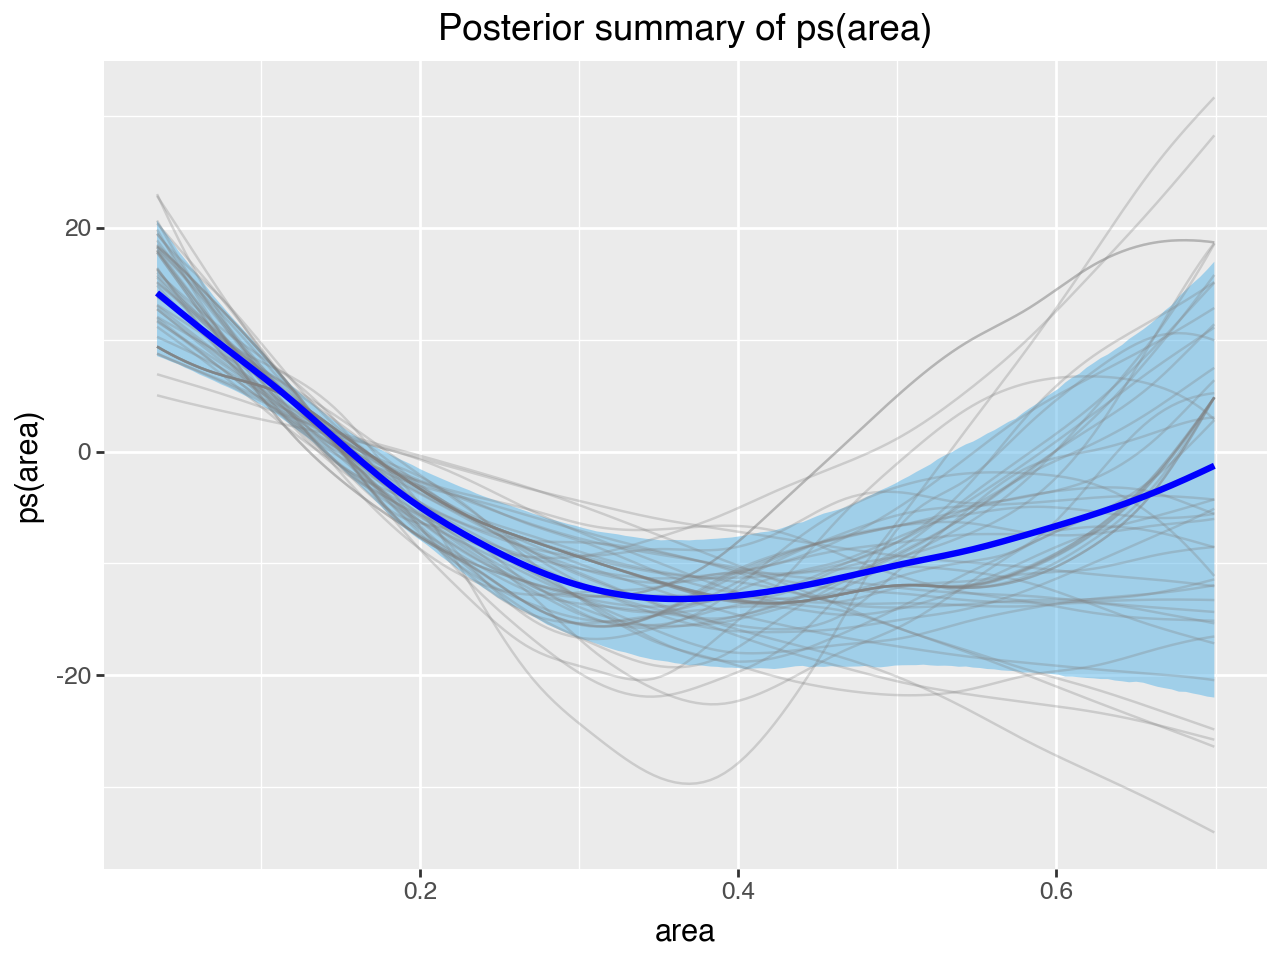

In [9]:
gam.plot_1d_smooth(term=model.vars[smooth.name], samples=samples)

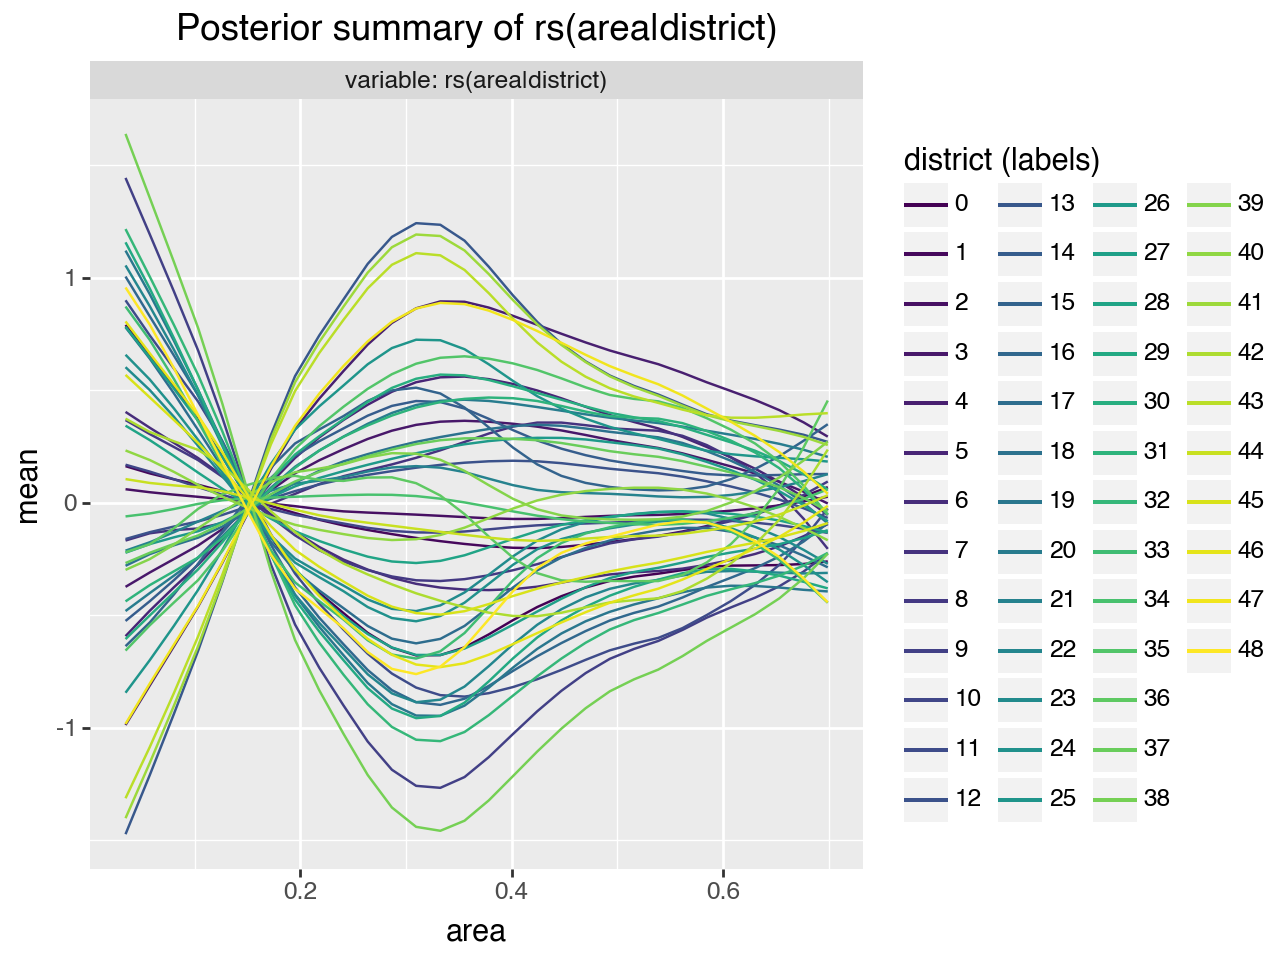

In [10]:
gam.plot_1d_smooth_clustered(
    clustered_term=model.vars["rs(area|district)"],
    samples=samples,
    ngrid=30,
)

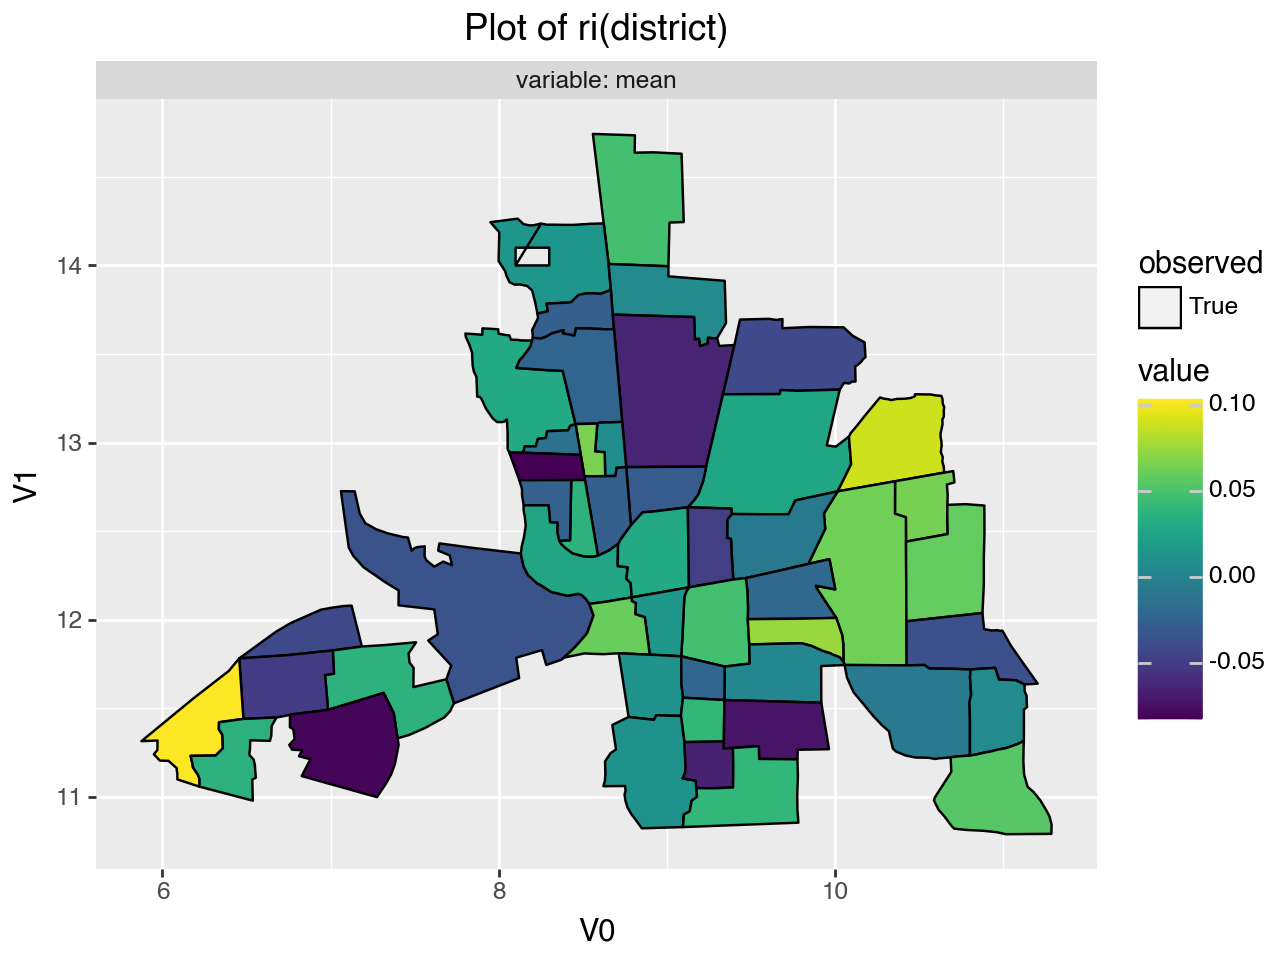

In [11]:
(
    gam.plot_regions(
        term=model.vars["ri(district)"],
        samples=samples,
        polys=polys,
        observed_color="black",
    )
)

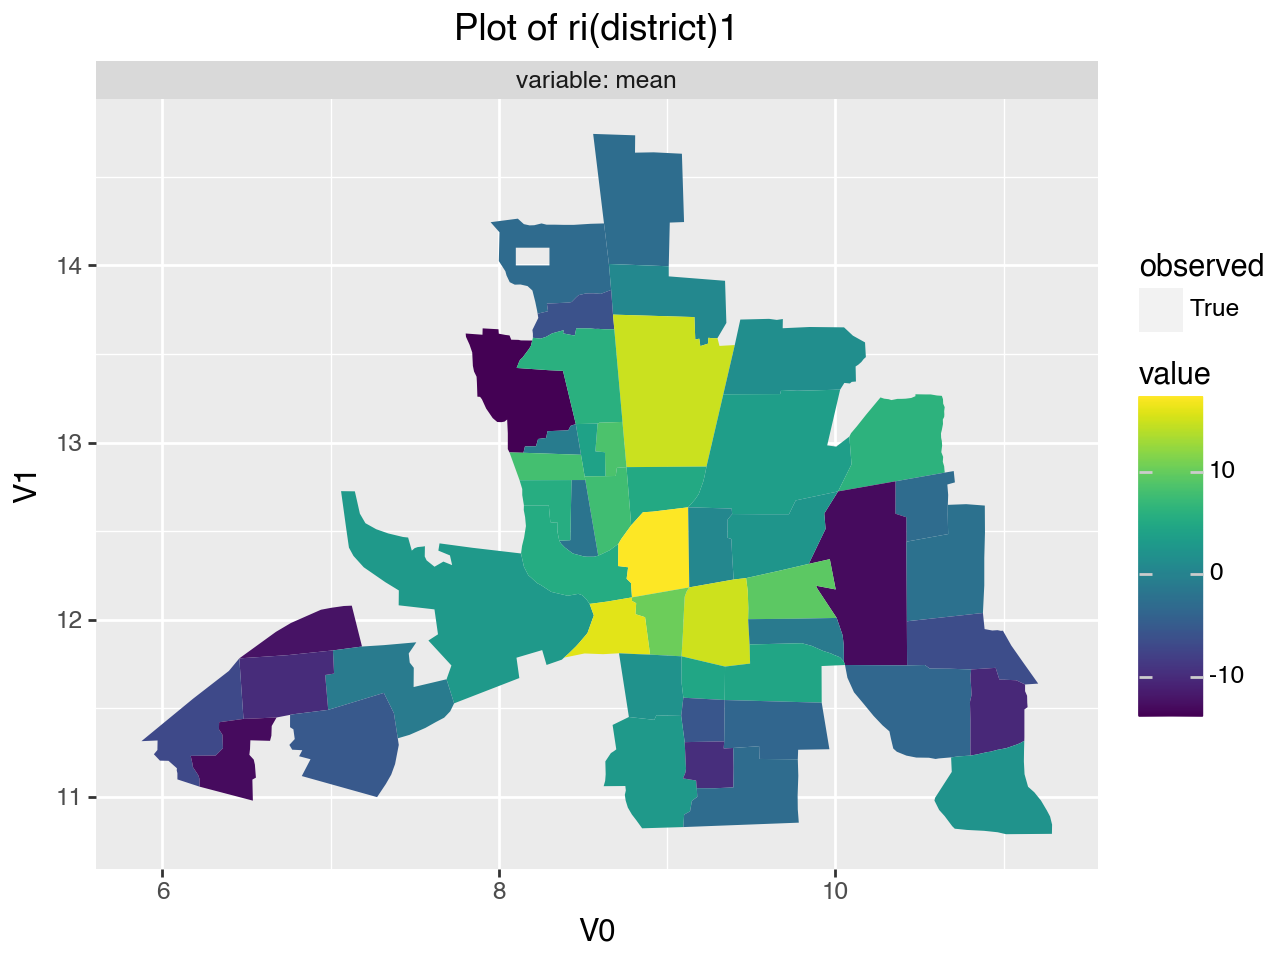

In [12]:
gam.plot_regions(term=model.vars["ri(district)1"], samples=samples, polys=polys)